In [40]:
"""Generated by Claude 3.5 Sonnet"""
import os
import json
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Directory containing event logs
event_dir = 'events'
log_files = sorted(glob.glob(os.path.join(event_dir, 'event_log_rank*.json')))

# Read and aggregate all events
events = []
for log_file in log_files:
    with open(log_file, 'r') as f:
        events.extend(json.load(f))

df = pd.DataFrame(events)
min_time = df['time'].min()

In [41]:
pd.set_option('display.float_format', '{:.2f}'.format)
df[df['rank'] == 1].sort_values(by=['time'])

,event,rank,step,time,epoch,batch
22,recv_fwd_start,1,0.00,1749130030.56,NaN,NaN
23,recv_fwd_end,1,0.00,1749130031.09,NaN,NaN
24,fwd_start,1,0.00,1749130031.09,NaN,NaN
25,fwd_end,1,0.00,1749130031.59,NaN,NaN
26,send_fwd_start,1,0.00,1749130031.59,NaN,NaN
27,send_fwd_end,1,0.00,1749130031.59,NaN,NaN
28,recv_fwd_start,1,1.00,1749130031.59,NaN,NaN
29,recv_fwd_end,1,1.00,1749130031.59,NaN,NaN
30,fwd_start,1,1.00,1749130031.59,NaN,NaN
31,fwd_end,1,1.00,1749130032.10,NaN,NaN


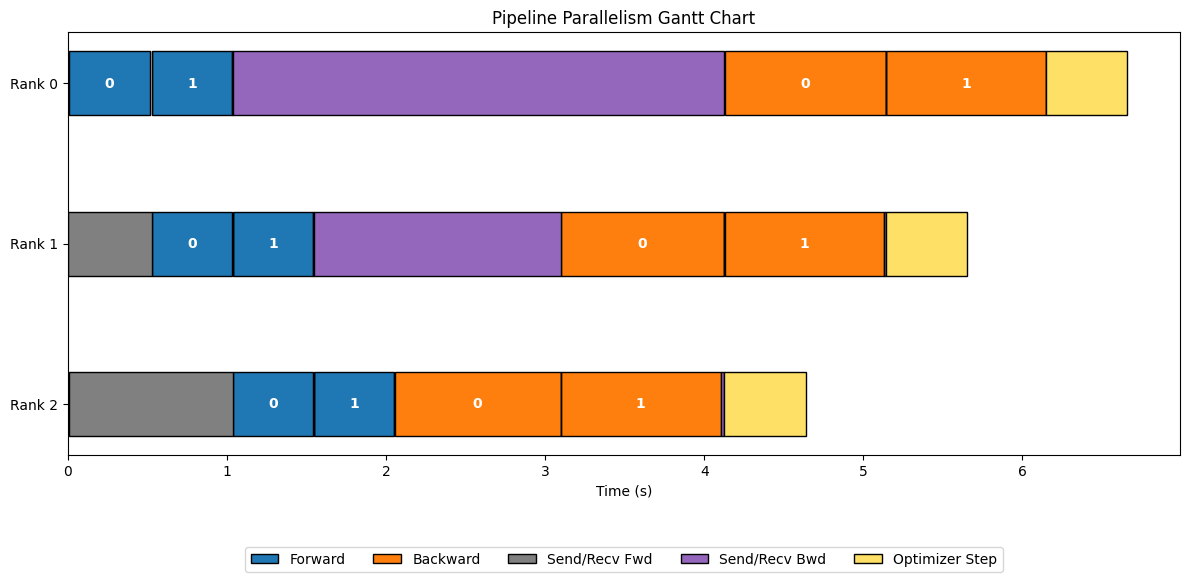

In [42]:
# Define event groups and colors
event_groups = {
    'fwd': ('fwd_start', 'fwd_end', 'Forward', '#1f77b4'),
    'bwd': ('bwd_start', 'bwd_end', 'Backward', '#ff7f0e'),
    'send_fwd': ('send_fwd_start', 'send_fwd_end', 'Send/Recv Fwd', '#808080'),
    'recv_fwd': ('recv_fwd_start', 'recv_fwd_end', 'Send/Recv Fwd', '#808080'),
    'send_bwd': ('send_bwd_start', 'send_bwd_end', 'Send/Recv Bwd', '#9467bd'),
    'recv_bwd': ('recv_bwd_start', 'recv_bwd_end', 'Send/Recv Bwd', '#9467bd'),
    'optimizer': ('optimizer_start', 'optimizer_end', 'Optimizer Step', '#ffe066'),
    # 'loss': ('fwd_start', 'fwd_end', 'Forward', '#ffff00'),# ('loss_start', 'loss_end', 'Loss', '#e377c2'),
}
# Prepare Gantt chart data
gantt_data = []
for rank in sorted(df['rank'].unique()):
    rank_df = df[df['rank'] == rank]
    for group, (start_evt, end_evt, label, color) in event_groups.items():
        starts = rank_df[rank_df['event'] == start_evt]
        ends = rank_df[rank_df['event'] == end_evt]
        for _, start_row in starts.iterrows():
            if not pd.isna(start_row['step']):
                end_row = ends[ends['step'] == start_row['step']]
            else:
                end_row = ends[ends['epoch'] == start_row['epoch']]
            if not end_row.empty:
                start_time = start_row['time']
                end_time = end_row.iloc[0]['time']
                gantt_data.append({
                    'rank': rank,
                    'event': label,
                    'start': start_time - min_time,
                    'end': end_time - min_time,
                    'color': color,
                    'annotation': str(int(start_row['step'])) if not pd.isna(start_row['step']) else ""
                })

# Plot
fig, ax = plt.subplots(figsize=(12, 2 * len(df['rank'].unique())))
y_labels = []
y_ticks = []

for i, rank in enumerate(sorted(df['rank'].unique())):
    y = i
    y_labels.append(f'Rank {rank}')
    y_ticks.append(y)
    for entry in gantt_data:
        if entry['rank'] == rank:
            ax.barh(y, entry['end'] - entry['start'], left=entry['start'], height=0.4, color=entry['color'], edgecolor='black', label=entry['event'])
            if entry['annotation'] and entry['event'] in ['Forward', 'Backward']:
                ax.text(
                    entry['start'] + (entry['end'] - entry['start']) / 2,
                    y,
                    entry['annotation'], 
                    va='center', ha='center', fontsize=10, color='white', fontweight='bold'
                )
# Remove duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(by_label))

ax.invert_yaxis()

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_xlabel('Time (s)')
ax.set_title('Pipeline Parallelism Gantt Chart')
plt.tight_layout()
plt.savefig('gantt_chart.png')
plt.show() 